In [1]:
#!pip install psycopg2
#!pip install pandas
#!pip install StatsForecast
#!pip install numpy==2.0
#!pip uninstall numba numpy

In [2]:
#!pip install --upgrade pip setuptools wheel



#!pip install "numba<1.0" "numpy<2.0"
#!pip install matplotlib


In [3]:
import psycopg2
import pandas as pd
import csv
from statsforecast import StatsForecast #- Para instanciar los  modelos
from statsforecast.models import Naive
from functools import partial
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import mape, mase, mse, smape
import numba
import matplotlib as mpl
import matplotlib.pyplot as plt

In [4]:

### verify the conexion
try:
    # Connect to the database
    conn = psycopg2.connect(
        host="pg.ujueta.com",
        port="5432",
        user="consultoria",
        password="LmKTXJBXya!14]f9!2k]",
        database="postgres",
    )
except psycopg2.Error as e:
    print("Error connecting to the database:")
    print(e)
else:
    print("Connection established successfully")

Connection established successfully


In [5]:

### ventas diario apiladas
def export_forecast_to_csv():
    try:
        # connect to the database
        conn = psycopg2.connect(
            host="pg.ujueta.com",
            port="5432",
            user="consultoria",
            password="LmKTXJBXya!14]f9!2k]",
            database="postgres",
        )

        # create cursor
        with conn.cursor() as cur:

            # ececute a sql query

            cur.execute("SELECT * FROM forecast.ventas_diario")

            # fetch the results
            results = cur.fetchall()

            # open a file in the downloads folder

            with open(
                "/home/usuario/Escritorio/Consultorias_Empresariales/Ujueta/Datos/outputs3.csv",
                "w",
                newline="",
            ) as f:
                # create a csv writer
                writer = csv.writer(f)

                # write the column names
                writer.writerow([col[0] for col in cur.description])

                # write the query results
                writer.writerows(results)
    except Exception as e:
        print(f"An error ocurred: {e}")
    finally:
        # close the cursor and connection
        if conn:
            conn.close()


# Call the function to export data to csv
export_forecast_to_csv()


In [6]:
### manipulate data
# carga de datas
data = pd.read_csv(
    "/home/usuario/Escritorio/Consultorias_Empresariales/Ujueta/Datos/outputs3.csv"
)
# convertir en dataframe
df = pd.DataFrame(data)
df.head()

,docdate,codigo_articulo,cantidad
0,2022-01-03,AUACALR4,1
1,2022-01-03,AUACCH1,5
2,2022-01-03,AUACPB400,1
3,2022-01-03,AUACRIM4F,5
4,2022-01-03,AUACSH1000,3


In [7]:
df.shape

(91563, 3)

In [8]:
def sumarizar_a_mensual(df, fecha_col, suma_col, agrupar_por=None):
    """
    Función para sumarizar datos diarios a un nivel mensual.

    Parámetros:
    ----------
    df : pd.DataFrame
        El DataFrame de entrada con los datos a procesar.
    fecha_col : str
        Nombre de la columna que contiene las fechas.
    suma_col : str
        Nombre de la columna cuyos valores se desean sumarizar.
    agrupar_por : list, optional
        Lista de columnas adicionales para agrupar (por defecto es None).
    
    Retorna:
    -------
    pd.DataFrame
        DataFrame con los datos agregados a nivel mensual.
    """
    # Asegurar que la columna de fecha esté en formato datetime
    df[fecha_col] = pd.to_datetime(df[fecha_col], errors='coerce')
    
    # Filtrar filas con fechas válidas
    df = df.dropna(subset=[fecha_col])
    
    # Crear la clave de agrupación mensual
    df['date'] = df[fecha_col].dt.to_period('M').dt.to_timestamp()

    # Configurar las columnas para agrupar
    group_cols = ['date'] + (agrupar_por if agrupar_por else [])

    # Realizar la agrupación y sumarización
    resultado = (
        df.groupby(group_cols, as_index=False)[suma_col]
        .sum()
    )

    return resultado


In [9]:
def get_best_model_forecast(forecasts_df, evaluation_df):
    # Clean and standardize column names
    forecasts_df.columns = forecasts_df.columns.str.strip().str.lower()
    evaluation_df['best_model'] = evaluation_df['best_model'].str.strip().str.lower()
    
    # Reset index to ensure 'unique_id' is a column
    forecasts_df = forecasts_df.reset_index()
    
    # Merge evaluation_df with forecasts_df
    merged_df = evaluation_df.merge(forecasts_df, on='unique_id', how='left')
    
    rows = []
    for _, row in merged_df.iterrows():
        best_model = row['best_model']
        
        # Validate best_model column
        if best_model not in forecasts_df.columns:
            raise KeyError(f"Model '{best_model}' not found in forecasts_df columns: {forecasts_df.columns.tolist()}")
        
        # Append the forecast value for the best model
        rows.append({'unique_id': row['unique_id'], 'ds': row['ds'], 'best_model': row[best_model]})
    
    # Convert to a dataframe
    result_df = pd.DataFrame(rows)
    return result_df

# Example usage
#prod_forecasts_df = get_best_model_forecast(forecasts_df=fcst_df, evaluation_df=evaluation_df)

#prod_forecasts_df

****

## Modelos dda extremandamente baja

In [10]:
low_cases = ['AUACAVANTI6000Z', 'AUACBOOM04F', 'AUACFS05', 'AUACHULK1500', 'AUACKCP900R', 'AUACKH160K',
            'AUACAC24NE600', 'AUACALK4', 'AUACBOOM02', 'AUACCRAB03', 'AUACHULK400S', 'AUACKCP501R',
            'AUACKCP801R', 'AUACKH60K', 'AUACKH80K', 'AUACKSH20', 'AUACMTD224', 'AUACRC4SC', 
             'AUACSPRING35L', 'AUACSPRING35R', 'AUACSPRING45L', 'AUACSPRING45R', 'AUACSPRING50L', 'AUACSPRING50R',
            'HEELEBA13850', 'MAEL2G80', 'SOELREPSI8250MG-R11', 'SOELREPSI8250MG-R12', 'SOELRSF1012', 'SOELRSS0608A',
            'SOFUFWA4011', 'SOSWG3-312', 'SOSWM1-113', 'SOSWM2-218', 'SOSWM2-272', 'SOSWM2-320',
            'SOSWM2-321', 'SOSWM2-324', 'SOSWM2-325', 'SOSWM2-328', 'SOSWP2-421', 'SOSWP2-424', 'SOSWSWW5070MV', 
            'HEELEBA11850', 'HEELEPBA634L', 'SOELRSS0910A', 'SOELRSS0910B', 'SOELRSS1012B', 'SOELSI9500MP',
            'SOELSIC45DVP', 'SOSWG3-316', 'SOSWG3-COOL', 'SOSWM1-125', 'SOSWM2-217', 'SOSWM2-249',
            'SOSWM2-253', 'SOSWM2-257', 'SOSWP1-340', 'SOSWP2-420', 'SOSWP2-425', 'SOSWP2-427',
            'SOSWREPM1-122E', 'SOSWSWT3545A', 'SOSWSWW3552', 'SOSWSWW4070MV', 'AUACRT4SC', 'AUACSPRING55L', 
             'HEELCS1427', 'HEELEBA150', 'HEELEBA3450', 'HEELEBA5850', 'HEELEBA7830', 'HEELEBA7850',
             'MADUDG123-A', 'SOELRSF0810A', 'SOELRSF0810B', 'SOELRSS0608B',
            'SOELSI8225XP', 'SOSWG3-314', 'SOSWM2-236', 'SOSWM2-238', 'SOSWM2-246', 'SOSWM2-274', 'SOSWSWT2033',
            'AUACAF24Li', 'AUACBOOM06T', 'AUACMTD624', 'AUACSC1800', 'AUACSPRING55R', 'AUACSPRING60L', 'AUACSPRING60R', 
             'AUACSPRING70L', 'AUACSPRING70R', 'AUACSPRING80L', 'AUACSPRING80R', 'AUELEP100240',
            'AUACSPRING60R', 'AUACSPRING70L', 'AUACSPRING70R', 'AUACSPRING80L', 'AUACSPRING80R', 'AUELEP100240', 'HEELRD1390',
            'AUAC4010', 'AUACAE15', 'AUACAF31C', 'AUACAP40', 'AUACAR10SC901', 'AUACAT63', 'AUACEG501', 'AUACFENIX601', 
             'AUACFEX10', 'AUACGC02', 'AUACKCP201R', 'AUACKCP250R', 'AUACKCP251C', 'AUACKCP351R', 'AUACKCP375C', 'AUACKCP376R', 
             'AUACKCP401R', 'AUACKCP450R', 'AUACKCP451C', 'AUACKCP490C', 'AUACKCP551R', 'AUACKCP575R', 'AUACKCP850R', 
             'AUACKCP875R', 'AUACKCP950R', 'AUACKCP975R', 'AUACKH100K', 'AUACLD500', 'AUACSB4', 'AUACSB9',
            'AUACSLB220', 'AUACVIPER100', 'AUELME624DC', 'AUELSL3000L', 'AUELSL5000', 'AUELSL5500L',
            'HEELDH2810', 'HEELDH4515', 'HEELEBA1230', 'HEELEBA1250', 'HEELEBA130', 'HEELEBA131630', 
             'HEELEBA3430', 'HEELEBA5830', 'HEELEPBA634C', 'HEELRM3209', 'HEELXB0520', 'SOSWG3-311',
            'SOSWG3-313', 'SOSWM1-117', 'SOSWM2-229', 'SOSWP1-330', 'SOSWP2-412', 'SOSWP2-413', 'SOSWP2-510', 
             'SOSWSWA2850', 'SOSWSWC1000', 'SOSWSWW2760','HEELBM5016', 'HEELCA5035', 'HEELDH1506',
             'HEELDH7531', 'HEELEBA111630', 'HEELEBA91630', 'HEELMT180KIT', 'HEELRM2604', 'HEELRM4210', 
             'HEELXBTP20', 'HEFUBFCD12', 'HEFUCBFCD12', 'HEFUFRM7024', 'MADUDG121-A', 'MADUDG23I', 'MADUDG401I', 
             'SOELCSVM500IP', 'SOELCSVM820', 'SOELCSVM830', 'SOFUFWA4014', 'SOSWC1-921', 'SOSWC1-931', 
             'SOSWC1-941', 'SOSWG1-112', 'SOSWG2-216', 'SOSWM2-210', 'SOSWM2-214', 'SOSWM2-215', 
             'SOSWM2-312', 'SOSWP2-414', 'SOSWP2-418', 'SOSWSWT2035', 'SOSWT1-112']   


#['SOSWM2-320', 'SOSWM2-321', 'SOSWM2-324', 'SOSWM2-325', 'SOSWM2-328', 'SOSWP2-424']

# Filter the dataset
extra_low = df[df['codigo_articulo'].isin(low_cases)]
extra_low

,docdate,codigo_articulo,cantidad
77,2022-01-04,AUACAF31C,1
84,2022-01-04,AUACKCP251C,1
160,2022-01-05,AUACKCP375C,1
161,2022-01-05,AUACKCP451C,1
265,2022-01-06,SOELREPSI8250MG-R11,2
...,...,...,...
91539,2024-12-19,SOSWG3-313,2
91541,2024-12-19,SOSWM1-113,1
91542,2024-12-19,SOSWM1-117,5
91545,2024-12-19,SOSWM2-229,4


In [11]:
len(extra_low['codigo_articulo'].unique())

188

In [12]:
extremely_low = ['SOSWM2-320', 'SOSWM2-321', 'SOSWM2-324', 'SOSWM2-325', 'SOSWM2-328', 'SOSWP2-424',
                 'HEFUFAG21B', 'HEFUFID21B', 'SOSWSWC1050MV', 'HEELXBLI20', 'HEFUFTS2010', 'SOELRSA1012', 
                 'SOELRSS0608A', 'SOFUFW405', 'SOFUFWA4011', 'SOSWG3-312', 'SOSWM2-249', 'SOSWP2-421']

# Filter the dataset
extra_low = df[~df['codigo_articulo'].isin(extremely_low)]
extra_low

,docdate,codigo_articulo,cantidad
0,2022-01-03,AUACALR4,1
1,2022-01-03,AUACCH1,5
2,2022-01-03,AUACPB400,1
3,2022-01-03,AUACRIM4F,5
4,2022-01-03,AUACSH1000,3
...,...,...,...
91558,2024-12-19,SOSWSWT2045,2
91559,2024-12-19,SOSWSWW2060N,2
91560,2024-12-19,SOSWSWW2550,1
91561,2024-12-19,SOSWSWW5070MV,1


In [13]:
len(extra_low['codigo_articulo'].unique())

437

In [14]:
len(extremely_low)

18

In [15]:
extra_low['codigo_articulo'].value_counts()

codigo_articulo
HEELAG1141             822
AUACRIM4F              811
SOFUFW181              786
SOELSI6140DV           785
HEFUFG71               777
                      ... 
AUACKH160K               5
SOSWP2-420               5
AUACSPRING35R            4
AUACSPRING35L            4
SOELREPSI8250MG-R12      3
Name: count, Length: 437, dtype: int64

In [16]:
extra_low.columns

Index(['docdate', 'codigo_articulo', 'cantidad'], dtype='object')

In [17]:
#========================================================================================================================================
# Ajuste de Datos para statsforecast
#========================================================================================================================================

#-- Dato de ejemplo para función

def data_sf(df, date = 'docdate', y = 'cantidad', unique_id = 'codigo_articulo'):
    df_m = df[[date, y, unique_id]]
    df_m.rename(columns={date : 'ds', y :'y', unique_id: 'unique_id'}, inplace=True)
  
    return df_m

df_extralow = data_sf(extra_low, date = 'docdate', y = 'cantidad', unique_id = 'codigo_articulo')
df_extralow
df_extralow.info()



<class 'pandas.core.frame.DataFrame'>
Index: 91508 entries, 0 to 91562
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ds         91508 non-null  object
 1   y          91508 non-null  int64 
 2   unique_id  91508 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [18]:
# monthly summarization 
df_lower = sumarizar_a_mensual(
    df_extralow, 
    fecha_col='ds', 
    suma_col='y', 
    agrupar_por=['unique_id']
)

df_lower.rename(columns={'date':'ds', 'unique_id':'unique_id', 'y':'y'}, inplace=True)
print(df_lower)

              ds      unique_id    y
0     2022-01-01        AUAC265    1
1     2022-01-01      AUAC3-4-1   70
2     2022-01-01     AUACAC24NE    2
3     2022-01-01       AUACAE15    1
4     2022-01-01       AUACAE20  138
...          ...            ...  ...
10134 2024-12-01    SOSWSWW3552    1
10135 2024-12-01  SOSWSWW4070MV    3
10136 2024-12-01  SOSWSWW5070MV    3
10137 2024-12-01     SOSWT1-111    3
10138 2024-12-01     SOSWT1-115    4

[10139 rows x 3 columns]


In [19]:
#========================================================================================================================================
# Colección de modelos
#========================================================================================================================================
from statsforecast import StatsForecast #- Para instanciar los  modelos
from statsforecast.models import Naive
from functools import partial
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import mape, mase, mse, smape
from statsforecast.models import (
    #AutoARIMA,
    #AutoETS,
    #HoltWinters,
    ADIDA,
    CrostonClassic as Croston, 
    IMAPA,
    TSB,
    #HistoricAverage,
    #DynamicOptimizedTheta as DOT,
    #Naive,
    #SeasonalNaive,
    #Theta,
    #WindowAverage,
    #Holt,
    #CrostonOptimized,
)

#-- Parametros

# Número de dias en el futuro a pronosticar
horizon = 2
# Ventana estacional: es 12 porque tenemos datos mensuales
season_length = 12
# El número de meses que el modelo usará para hacer el forecast 
window_size = 10

# Lista de modelos a evaluar
models = [
    #AutoARIMA(season_length=season_length),
    #AutoETS(season_length=season_length),
    #HoltWinters(season_length=season_length),
    ADIDA(),   # could produce zero division
    Croston(),  # could produce zero division
    IMAPA(),   # could produce zero division
    TSB(alpha_d = 0.2, alpha_p = 0.2),
    #HistoricAverage(),
    #DOT(season_length=season_length),
    #Naive(),
   # SeasonalNaive(season_length=season_length),
    #Theta(),  # could produce zero division
    #WindowAverage(window_size=7),  # Adjust `window_size` as needed
    #Holt(),
    #CrostonOptimized()
]

In [20]:
# StatsForecast.plot(df_m)

# Instanciando StatsForecast como sf
sf = StatsForecast( 
    models=models,
    freq='M', #MS
    n_jobs=-1,
)


In [21]:
from functools import partial
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import mape, mase, mse, smape

try:
    crossvaldation_dflower = sf.cross_validation(
        df=df_lower,
        h=horizon,
        step_size=horizon,
        n_windows=1
    )
except ZeroDivisionError as e:
    print(f"Error: {e}")

/home/usuario/myenv/lib/python3.12/site-packages/statsforecast/core.py:494: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [22]:
def evaluate_cross_validation(df, metric):
    models = df.drop(columns=['unique_id', 'ds', 'cutoff', 'y'], errors='ignore').columns.tolist()
    evals = []
    # Calculate loss for every unique_id and cutoff.    
    for cutoff in df['cutoff'].unique():
        eval_ = evaluate(df[df['cutoff'] == cutoff], metrics=[metric], models=models)
        evals.append(eval_)
    evals = pd.concat(evals)
    evals = evals.groupby('unique_id').mean(numeric_only=True) # Averages the error metrics for all cutoffs for every combination of model and unique_id
    evals['best_model'] = evals.idxmin(axis=1)
    return evals

evaluation_df = evaluate_cross_validation(crossvaldation_dflower.reset_index(drop=False), smape)
evaluation_df.head(22)

,ADIDA,CrostonClassic,IMAPA,TSB,best_model
unique_id,,,,,
AUAC265,0.246895,0.208472,0.246895,0.252921,CrostonClassic
AUAC3-4-1,0.799734,0.807810,0.799734,0.795046,TSB
AUAC4010,0.276499,0.256429,0.276499,0.173393,TSB
AUACAC24NE,0.326257,0.332498,0.326257,0.329743,ADIDA
AUACAC24NE600,0.352490,0.315135,0.352490,0.354801,CrostonClassic
AUACAE15,0.224897,0.220930,0.224897,0.258739,CrostonClassic
AUACAE20,0.352668,0.383677,0.352668,0.397958,ADIDA
AUACAE25,0.433432,0.425147,0.433432,0.429938,CrostonClassic
AUACAE30,0.120521,0.120783,0.120521,0.120400,TSB


In [23]:
#--- Selección del mejor modelo
fcst_dflow = sf.forecast(df=df_lower, 
                      h=horizon, 
                      ## level=[90]
                     )
fcst_dflow.head(10)

/home/usuario/myenv/lib/python3.12/site-packages/utilsforecast/processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/home/usuario/myenv/lib/python3.12/site-packages/utilsforecast/processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/home/usuario/myenv/lib/python3.12/site-packages/statsforecast/core.py:494: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


,ds,ADIDA,CrostonClassic,IMAPA,TSB
unique_id,,,,,
AUAC265,2024-12-31,30.660114,30.264889,30.660114,31.182028
AUAC265,2025-01-31,30.660114,30.264889,30.660114,31.182028
AUAC3-4-1,2024-12-31,147.223801,177.686569,147.223801,134.744659
AUAC3-4-1,2025-01-31,147.223801,177.686569,147.223801,134.744659
AUAC4010,2024-12-31,11.101096,10.220172,11.101096,12.697098
AUAC4010,2025-01-31,11.101096,10.220172,11.101096,12.697098
AUACAC24NE,2024-12-31,13.314595,11.457943,13.314595,12.782203
AUACAC24NE,2025-01-31,13.314595,11.457943,13.314595,12.782203
AUACAC24NE600,2024-12-31,2.979694,3.197581,2.979694,3.137653


/home/usuario/myenv/lib/python3.12/site-packages/statsforecast/core.py:1407: FutureWarning: Passing the ids as the index is deprecated. Please provide them as a column instead.
  warnings.warn(


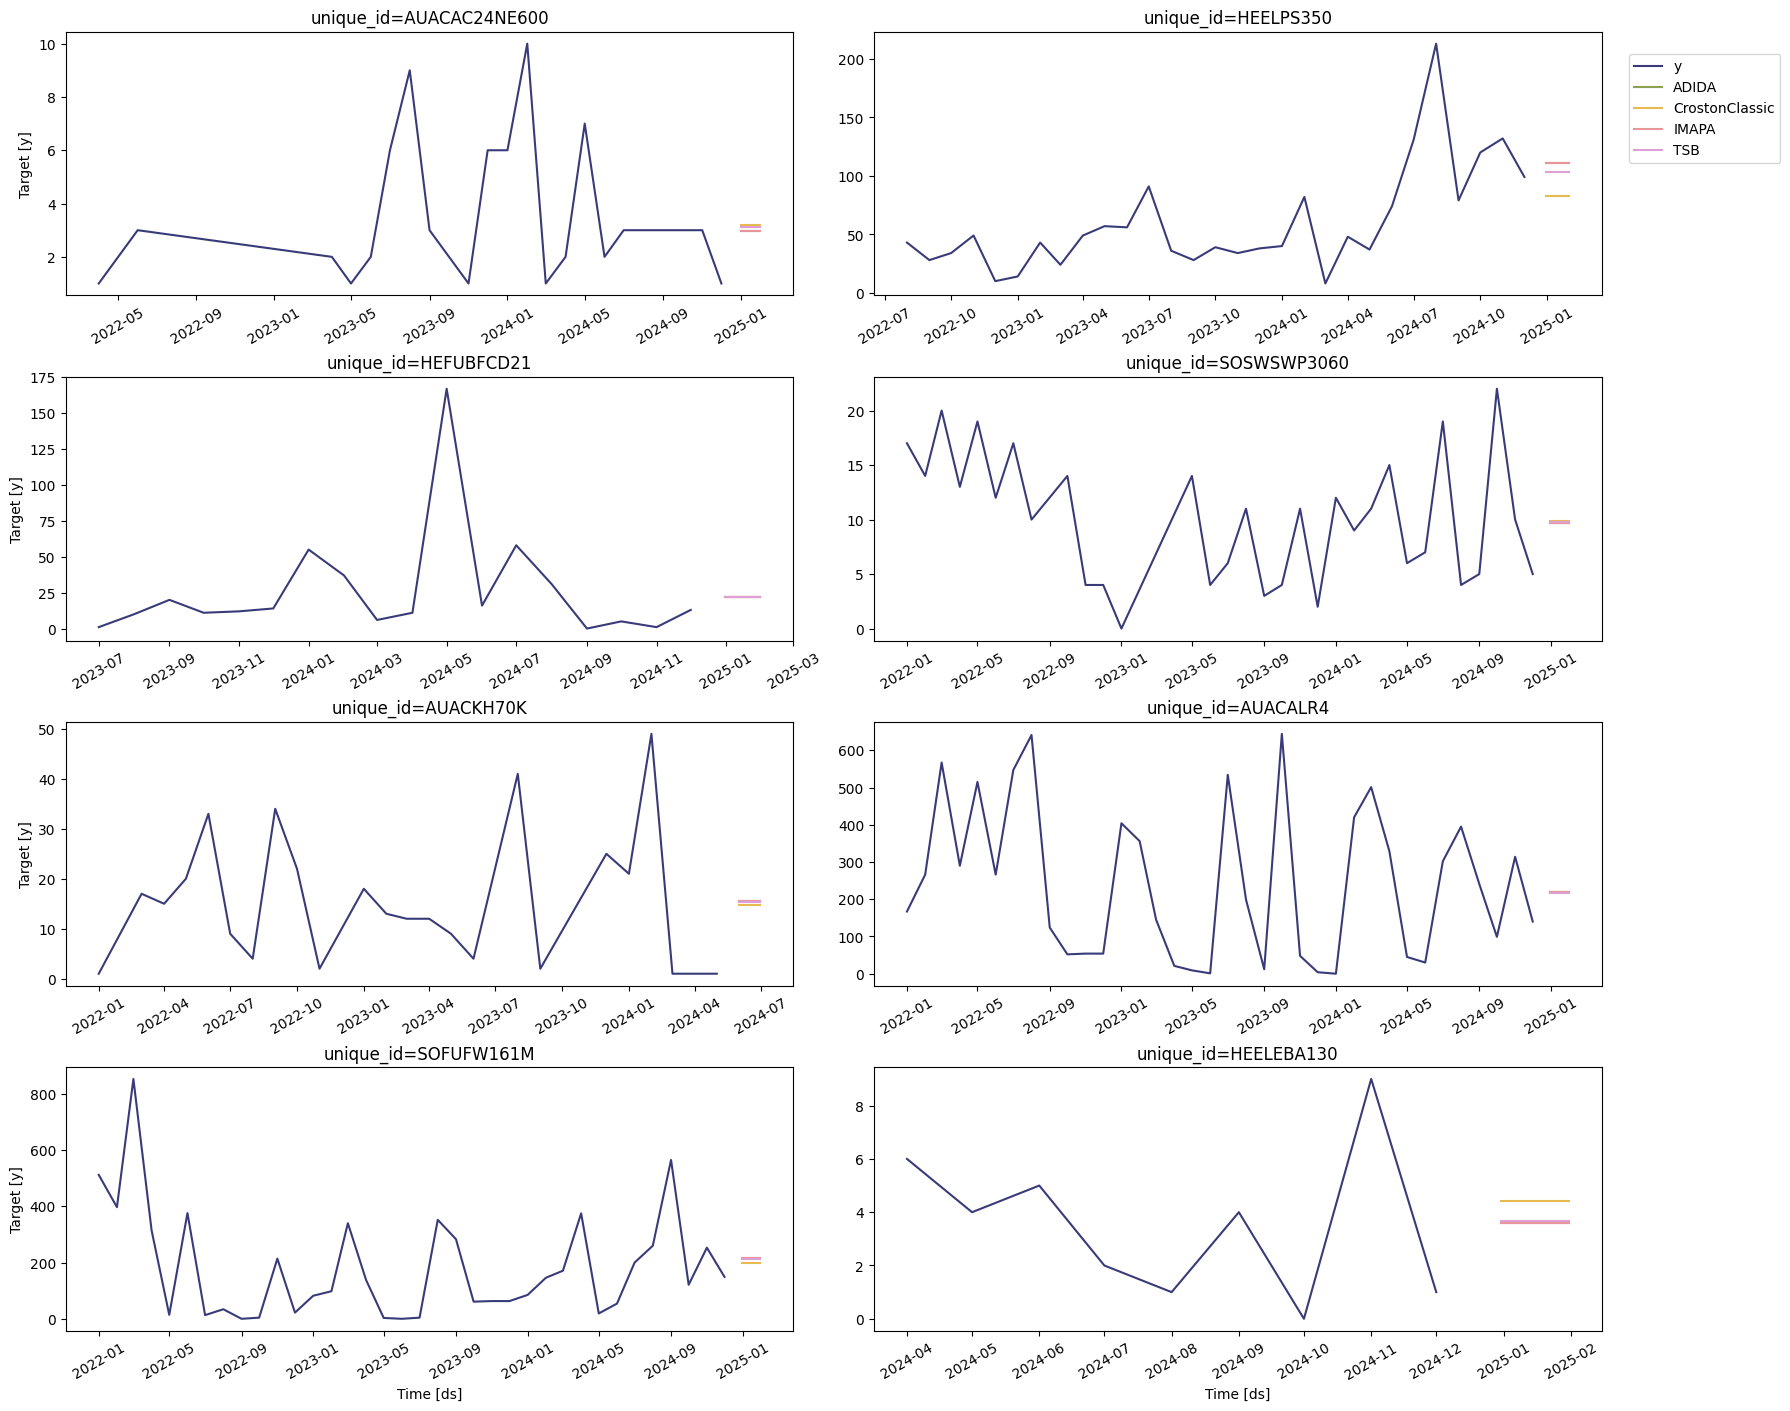

In [24]:
sf.plot(df_lower,fcst_dflow)

In [25]:
# Example usage
prod_forecasts_df = get_best_model_forecast(forecasts_df=fcst_dflow, evaluation_df=evaluation_df)

prod_forecasts_df

,unique_id,ds,best_model
0,AUAC265,2024-12-31,30.264889
1,AUAC265,2025-01-31,30.264889
2,AUAC3-4-1,2024-12-31,134.744659
3,AUAC3-4-1,2025-01-31,134.744659
4,AUAC4010,2024-12-31,12.697098
...,...,...,...
869,SOSWT1-111,2025-01-31,20.116449
870,SOSWT1-112,2024-09-30,3.254580
871,SOSWT1-112,2024-10-31,3.254580
872,SOSWT1-115,2024-12-31,8.365922


In [26]:
prod_forecasts_df[prod_forecasts_df['unique_id'] == 'AUAC265']

,unique_id,ds,best_model
0,AUAC265,2024-12-31,30.264889
1,AUAC265,2025-01-31,30.264889


In [27]:
prod_forecasts_df[prod_forecasts_df['unique_id'] == 'SOSWT1-115']

,unique_id,ds,best_model
872,SOSWT1-115,2024-12-31,8.365922
873,SOSWT1-115,2025-01-31,8.365922
